This notebook is downloaded from: https://www.kaggle.com/tommy1028/lightgbm-starter-with-feature-engineering-idea

# LightGBM starter with feature engineering idea
***I am creating this note mostly for myself to re-organize my ideas. Please leave your comments and/or advice if you find the room I can improve my coding/model builing to go further.***


We will predict **the realized volatility of the next ten-minutes time window** with two data sets of the last ten minutes (600 seconds).One dataset contains ask and bid prices of almost each second, which allows us to calculate the realized volatility of the last ten minutes.The other dataset contains the actual record of stock trading, which is more sparse.

Please look at this notebook for the detailed explanation: https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data

As for EDA, you may find this notebook useful: https://www.kaggle.com/chumajin/optiver-realized-eda-for-starter-english-version

Thank you!

### Contribution from the commmunity
**The codes for showing Feature Importance is kindly prepared by this expert: https://www.kaggle.com/something4kag
and extracted by this notebook: https://www.kaggle.com/something4kag/lightgbm-starter-with-fe-and-importance**

## My approach(work in progress)
### Feature Engineering

Here are my thoughts on feature engieering with my background knowledge on financial market. 

 - price_spread: the difference between ask price and bid price. Wide spread means low liquidity, leading to high volatility.
 - volume: the sum of the ask/bid size. Low volume means low liquidity, leading to high volatility
 - volume_imbalance: the difference between ask size and bid size. Large imbalance means low liquidity for one side, leading to high volatility
 
Also, I created features only using last XX seconds to capture the dynamics of volatility further.


### Model Building
- optimize the weight for RMSPE: see this discussion https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/250324
- one model for all stocks: model by stock_id does not work well. I am afraid of overfitting as well. stock_id is used as categorical and for target mean encoding.

## Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

import os
import glob

In [2]:
# data directory
data_dir = 'data/'

## Functions for preprocess

In [3]:
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

In [4]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [5]:
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

In [6]:
def count_unique(series):
    return len(np.unique(series))

## Main function for preprocessing book data

In [7]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    #calculate return etc
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
            }

    ##### groupby / all seconds
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ###### groupby / last XX seconds
    last_seconds = [200, 300, 400]
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] # time_id is changed to time_id_
     
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    # create row_id
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)
    
    return df_feature

In [8]:
%%time
file_path = data_dir + "book_train.parquet/stock_id=0"
preprocessor_book(file_path)

Wall time: 12 s


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_400,log_return2_realized_volatility_400,wap_balance_mean_400,price_spread_mean_400,bid_spread_mean_400,ask_spread_mean_400,volume_imbalance_mean_400,total_volume_mean_400,wap_mean_400,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_200,log_return2_realized_volatility_200,wap_balance_mean_200,price_spread_mean_200,bid_spread_mean_200,ask_spread_mean_200,volume_imbalance_mean_200,total_volume_mean_200,wap_mean_200,row_id
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002300,0.004589,0.000390,0.000783,0.000214,-0.000191,124.326531,262.489796,1.003633,0.002953,0.004864,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0.003402,0.005803,0.000379,0.000865,0.000205,-0.000155,134.772021,321.455959,1.003836,0-5
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000934,0.001907,0.000261,0.000367,0.000186,-0.000133,96.136986,480.000000,1.000480,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0.001014,0.002105,0.000210,0.000348,0.000139,-0.000123,151.407895,438.921053,1.000332,0-11
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001179,0.003034,0.000411,0.000625,0.000167,-0.000204,152.509804,454.000000,0.998356,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0.001940,0.003900,0.000396,0.000683,0.000146,-0.000263,143.514851,440.544554,0.998944,0-16
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001003,0.001513,0.000350,0.001050,0.000155,-0.000048,153.826087,498.956522,0.998079,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0.001855,0.002881,0.000339,0.000856,0.000133,-0.000114,137.217391,424.782609,0.998472,0-31
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001434,0.001516,0.000298,0.000469,0.000209,-0.000126,85.618182,339.945455,0.999473,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0.001571,0.002461,0.000230,0.000414,0.000174,-0.000108,116.956140,388.394737,0.999575,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.002579,0.003821,0.000212,0.000552,0.000083,-0.000182,197.144781,374.235690,0.997938,0.001411,0.002306,0.000167,0.000447,0.000068,-0.000197,220.857143,317.296703,0.996927,0.001673,0.002573,0.000193,0.000509,0.000062,-0.000169,233.946667,350.560000,0.997519,0.002247,0.003328,0.000223,0.000558,0.000067,-0.000176,207.519608,341.882353,0.997725,0-32751
3826,0.002206,0.002847,0.000267,0.000542,0.000092,-0.000172,233.781553,621.131068,1.000310,0.001288,0.001866,0.000263,0.000555,0.000083,-0.000192,250.672414,566.017241,1.000753,0.001487,0.002255,0.000300,0.000588,0.000074,-0.000177,257.920000,668.640000,1.000682,0.001496,0.002315,0.000293,0.000570,0.000082,-0.000180,262.807407,694.985185,1.000543,0-32753
3827,0.002913,0.003266,0.000237,0.000525,0.000202,-0.000083,115.829787,343.734043,0.999552,0.001511,0.002365,0.000226,0.000470,0.000177,-0.000082,109.246753,335.272727,1.000220,0.001928,0.002646,0.000216,0.000446,0.000191,-0.000075,105.432692,326.759615,1.000111,0.001963,0.002842,0.000223,0.000458,0.000213,-0.000072,111.068966,318.155172,1.000001,0-32758
3828,0.003046,0.005105,0.000245,0.000480,0.000113,-0.000166,132.074919,385.429967,1.002357,0.001617,0.002919,0.000242,0.000503,0.000104,-0.000169,115.728155,435.165049,1.002305,0.002137,0.003934

In [9]:
trade_train = pd.read_parquet(data_dir + "trade_train.parquet/stock_id=0")
trade_train.head(15)

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
5,5,78,1.003762,134,5
6,5,122,1.004207,102,3
7,5,127,1.004577,1,1
8,5,144,1.004370,6,1
9,5,147,1.003964,233,4


## Main function for preprocessing trade data

In [10]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [200, 300, 400]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

In [11]:
%%time
file_path = data_dir + "trade_train.parquet/stock_id=0"
preprocessor_trade(file_path)

Wall time: 5.79 s


,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_mean_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_mean_200,row_id
0,0.002006,40,3179,2.750000,0.001121,16.0,1045.0,2.437500,0.001308,21.0,1587.0,2.571429,0.001666,27.0,1901.0,2.555556,0-5
1,0.000901,30,1289,1.900000,0.000510,11.0,829.0,2.090909,0.000587,16.0,900.0,2.250000,0.000802,22.0,1124.0,2.045455,0-11
2,0.001961,25,2161,2.720000,0.001048,10.0,1087.0,3.400000,0.001137,12.0,1189.0,3.166667,0.001575,18.0,1691.0,2.833333,0-16
3,0.001561,15,1962,3.933333,0.000802,3.0,514.0,3.666667,0.001089,9.0,1556.0,5.111111,0.001090,10.0,1561.0,4.700000,0-31
4,0.000871,22,1791,4.045455,0.000395,6.0,162.0,3.666667,0.000453,11.0,1219.0,4.909091,0.000498,14.0,1458.0,4.428571,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.001519,52,3450,3.057692,0.000911,28.0,1856.0,3.142857,0.001162,35.0,2365.0,3.257143,0.001257,39.0,2407.0,3.128205,0-32751
3826,0.001411,28,4547,3.892857,0.000765,6.0,1401.0,5.166667,0.001066,12.0,2161.0,4.250000,0.001235,18.0,2493.0,3.555556,0-32753
3827,0.001521,36,4250,3.500000,0.000875,13.0,1149.0,2.692308,0.001242,22.0,2294.0,3.727273,0.001243,23.0,2295.0,3.608696,0-32758
3828,0.001794,53,3217,2.150943,0.001070,16.0,1463.0,2.312500,0.001404,25.0,1627.0,1.920000,0.001622,33.0,2171.0,2.030303,0-32763


## Combined preprocessor function

In [12]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df


In [13]:
list_stock_ids = [0,1]
preprocessor(list_stock_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.0s finished


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_400,log_return2_realized_volatility_400,wap_balance_mean_400,price_spread_mean_400,bid_spread_mean_400,ask_spread_mean_400,volume_imbalance_mean_400,total_volume_mean_400,wap_mean_400,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_200,log_return2_realized_volatility_200,wap_balance_mean_200,price_spread_mean_200,bid_spread_mean_200,ask_spread_mean_200,volume_imbalance_mean_200,total_volume_mean_200,wap_mean_200,row_id,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_mean_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_mean_200
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002300,0.004589,0.000390,0.000783,0.000214,-0.000191,124.326531,262.489796,1.003633,0.002953,0.004864,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0.003402,0.005803,0.000379,0.000865,0.000205,-0.000155,134.772021,321.455959,1.003836,0-5,0.002006,40,3179,2.750000,0.001121,16.0,1045.0,2.437500,0.001308,21.0,1587.0,2.571429,0.001666,27.0,1901.0,2.555556
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000934,0.001907,0.000261,0.000367,0.000186,-0.000133,96.136986,480.000000,1.000480,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0.001014,0.002105,0.000210,0.000348,0.000139,-0.000123,151.407895,438.921053,1.000332,0-11,0.000901,30,1289,1.900000,0.000510,11.0,829.0,2.090909,0.000587,16.0,900.0,2.250000,0.000802,22.0,1124.0,2.045455
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001179,0.003034,0.000411,0.000625,0.000167,-0.000204,152.509804,454.000000,0.998356,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0.001940,0.003900,0.000396,0.000683,0.000146,-0.000263,143.514851,440.544554,0.998944,0-16,0.001961,25,2161,2.720000,0.001048,10.0,1087.0,3.400000,0.001137,12.0,1189.0,3.166667,0.001575,18.0,1691.0,2.833333
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001003,0.001513,0.000350,0.001050,0.000155,-0.000048,153.826087,498.956522,0.998079,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0.001855,0.002881,0.000339,0.000856,0.000133,-0.000114,137.217391,424.782609,0.998472,0-31,0.001561,15,1962,3.933333,0.000802,3.0,514.0,3.666667,0.001089,9.0,1556.0,5.111111,0.001090,10.0,1561.0,4.700000
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001434,0.001516,0.000298,0.000469,0.000209,-0.000126,85.618182,339.945455,0.999473,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0.001571,0.002461,0.000230,0.000414,0.000174,-0.000108,116.956140,388.394737,0.999575,0-62,0.000871,22,1791,4.045455,0.000395,6.0,162.0,3.666667,0.000453,11.0,1219.0,4.909091,0.000498,14.0,1458.0,4.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7655,0.003723,0.004996,0.000330,0.000597,0.000157,-0.000118,125.013029,296.185668,1.000142,0.001584,0.001957,0.000268,0.000605,0.000

## Training set

In [14]:
train = pd.read_csv(data_dir + 'train.csv')

In [15]:
train_ids = train.stock_id.unique()

In [16]:
%%time
df_train = preprocessor(list_stock_ids= train_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.7min
C:\Users\yzho0040\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  6.1min finished


Wall time: 6min 6s


In [17]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train, on = ['row_id'], how = 'left')

In [27]:
df_train.to_csv('train_data.csv')

## Test set

In [19]:
test = pd.read_csv(data_dir + 'test.csv')

In [20]:
test_ids = test.stock_id.unique()

In [21]:
%%time
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Wall time: 363 ms


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [22]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')

In [28]:
df_test.to_csv('data/test_data.csv')

## Target encoding by stock_id

In [34]:
df_train = pd.read_csv('data/train_data.csv', index_col=0)
df_test = pd.read_csv('data/test_data.csv', index_col=0)

In [35]:
from sklearn.model_selection import KFold
#stock_id target encoding
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

## Model Building

In [36]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_400,log_return2_realized_volatility_400,wap_balance_mean_400,price_spread_mean_400,bid_spread_mean_400,ask_spread_mean_400,volume_imbalance_mean_400,total_volume_mean_400,wap_mean_400,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_200,log_return2_realized_volatility_200,wap_balance_mean_200,price_spread_mean_200,bid_spread_mean_200,ask_spread_mean_200,volume_imbalance_mean_200,total_volume_mean_200,wap_mean_200,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_mean_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_mean_200,stock_id,stock_id_target_enc
0,0-5,0.004136,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002300,0.004589,0.000390,0.000783,0.000214,-0.000191,124.326531,262.489796,1.003633,0.002953,0.004864,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0.003402,0.005803,0.000379,0.000865,0.000205,-0.000155,134.772021,321.455959,1.003836,0.002006,40.0,3179.0,2.750000,0.001121,16.0,1045.0,2.437500,0.001308,21.0,1587.0,2.571429,0.001666,27.0,1901.0,2.555556,0,0.004041
1,0-11,0.001445,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000934,0.001907,0.000261,0.000367,0.000186,-0.000133,96.136986,480.000000,1.000480,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0.001014,0.002105,0.000210,0.000348,0.000139,-0.000123,151.407895,438.921053,1.000332,0.000901,30.0,1289.0,1.900000,0.000510,11.0,829.0,2.090909,0.000587,16.0,900.0,2.250000,0.000802,22.0,1124.0,2.045455,0,0.004039
2,0-16,0.002168,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001179,0.003034,0.000411,0.000625,0.000167,-0.000204,152.509804,454.000000,0.998356,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0.001940,0.003900,0.000396,0.000683,0.000146,-0.000263,143.514851,440.544554,0.998943,0.001961,25.0,2161.0,2.720000,0.001048,10.0,1087.0,3.400000,0.001137,12.0,1189.0,3.166667,0.001575,18.0,1691.0,2.833333,0,0.004041
3,0-31,0.002195,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998831,0.001003,0.001513,0.000350,0.001050,0.000155,-0.000048,153.826087,498.956522,0.998079,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0.001855,0.002881,0.000339,0.000856,0.000133,-0.000114,137.217391,424.782609,0.998472,0.001561,15.0,1962.0,3.933333,0.000802,3.0,514.0,3.666667,0.001089,9.0,1556.0,5.111111,0.001090,10.0,1561.0,4.700000,0,0.004013
4,0-62,0.001747,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001434,0.001516,0.000298,0.000469,0.000209,-0.000126,85.618182,339.945455,0.999473,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0.001571,0.002461,0.000230,0.000414,0.000174,-0.000108,116.956140,388.394737,0.999575,0.000871,22.0,1791.0,4.045455,0.000395,6.0,162.0,3.666667,0.000453,11.0,1219.0,4.909091,0.000498,14.0,1458.0,4.428571,0,0.004032


In [37]:
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_400,log_return2_realized_volatility_400,wap_balance_mean_400,price_spread_mean_400,bid_spread_mean_400,ask_spread_mean_400,volume_imbalance_mean_400,total_volume_mean_400,wap_mean_400,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_200,log_return2_realized_volatility_200,wap_balance_mean_200,price_spread_mean_200,bid_spread_mean_200,ask_spread_mean_200,volume_imbalance_mean_200,total_volume_mean_200,wap_mean_200,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_mean_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_mean_200,stock_id_target_enc
0,0,4,0-4,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,350.666667,1.000405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000295,3.0,201.0,3.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [26]:
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True

## LightGBM

In [38]:
import lightgbm as lgbm

In [31]:
# ref https://www.kaggle.com/corochann/permutation-importance-for-feature-selection-part1
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [39]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

In [40]:
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [46]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# def feval_RMSPE(preds, lgbm_train):
#     labels = lgbm_train.get_label()
#     return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

In [47]:
from sklearn.metrics import make_scorer
my_score = make_scorer(rmspe, greater_is_better=False, needs_proba=False)

In [ ]:
params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

### Cross Validation

In [48]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

# gain_importance_list = []
# split_importance_list = []

In [36]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=100,
                      categorical_feature = ['stock_id']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
#     if DO_FEAT_IMP:    
#         feature_names = X_train.columns.values.tolist()
#         gain_importance_df = calc_model_importance(
#             model, feature_names=feature_names, importance_type='gain')
#         gain_importance_list.append(gain_importance_df)

#         split_importance_df = calc_model_importance(
#             model, feature_names=feature_names, importance_type='split')
#         split_importance_list.append(split_importance_df)

Fold : 1


C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13573
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 54
[LightGBM] [Info] Start training from score 0.001800
Training until validation scores don't improve for 30 rounds


C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000659295	training's RMSPE: 0.30512	valid_1's rmse: 0.000662775	valid_1's RMSPE: 0.3068
[200]	training's rmse: 0.00053471	training's RMSPE: 0.24746	valid_1's rmse: 0.000541302	valid_1's RMSPE: 0.25057
[300]	training's rmse: 0.000508585	training's RMSPE: 0.23537	valid_1's rmse: 0.000516515	valid_1's RMSPE: 0.23909
[400]	training's rmse: 0.000500891	training's RMSPE: 0.23181	valid_1's rmse: 0.000509936	valid_1's RMSPE: 0.23605
[500]	training's rmse: 0.000496929	training's RMSPE: 0.22997	valid_1's rmse: 0.000507195	valid_1's RMSPE: 0.23478
[600]	training's rmse: 0.000494083	training's RMSPE: 0.22866	valid_1's rmse: 0.00050564	valid_1's RMSPE: 0.23406
[700]	training's rmse: 0.00049158	training's RMSPE: 0.2275	valid_1's rmse: 0.000504307	valid_1's RMSPE: 0.23344
[800]	training's rmse: 0.000489363	training's RMSPE: 0.22647	valid_1's rmse: 0.000503197	valid_1's RMSPE: 0.23293
[900]	training's rmse: 0.000487375	training's RMSPE: 0.22555	valid_1's rmse: 0.000502371	vali

C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13574
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 54
[LightGBM] [Info] Start training from score 0.001795


C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000658751	training's RMSPE: 0.30554	valid_1's rmse: 0.000661527	valid_1's RMSPE: 0.30348
[200]	training's rmse: 0.000533985	training's RMSPE: 0.24767	valid_1's rmse: 0.000540543	valid_1's RMSPE: 0.24797
[300]	training's rmse: 0.000507838	training's RMSPE: 0.23555	valid_1's rmse: 0.000516976	valid_1's RMSPE: 0.23716
[400]	training's rmse: 0.000500168	training's RMSPE: 0.23199	valid_1's rmse: 0.000511061	valid_1's RMSPE: 0.23445
[500]	training's rmse: 0.000496191	training's RMSPE: 0.23014	valid_1's rmse: 0.000508551	valid_1's RMSPE: 0.2333
[600]	training's rmse: 0.000493355	training's RMSPE: 0.22883	valid_1's rmse: 0.000507172	valid_1's RMSPE: 0.23267
[700]	training's rmse: 0.000490884	training's RMSPE: 0.22768	valid_1's rmse: 0.000506012	valid_1's RMSPE: 0.23213
[800]	training's rmse: 0.000488692	training's RMSPE: 0.22667	valid_1's rmse: 0.000505023	valid_1's RMSPE: 0.23168
[900]	training's rmse: 0.000

C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13573
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 54
[LightGBM] [Info] Start training from score 0.001800
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000659546	training's RMSPE: 0.30524	valid_1's rmse: 0.000661519	valid_1's RMSPE: 0.3062
[200]	training's rmse: 0.000534911	training's RMSPE: 0.24755	valid_1's rmse: 0.00054033	valid_1's RMSPE: 0.25011
[300]	training's rmse: 0.000508684	training's RMSPE: 0.23542	valid_1's rmse: 0.000515918	valid_1's RMSPE: 0.23881
[400]	training's rmse: 0.000501011	training's RMSPE: 0.23187	valid_1's rmse: 0.000509641	valid_1's RMSPE: 0.2359
[500]	training's rmse: 0.000496979	training's RMSPE: 0.23	valid_1's rmse: 0.000507096	valid_1's RMSPE: 0.23472
[600]	training's rmse: 0.000

C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13573
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 54
[LightGBM] [Info] Start training from score 0.001805
Training until validation scores don't improve for 30 rounds


C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000659171	training's RMSPE: 0.30461	valid_1's rmse: 0.000666935	valid_1's RMSPE: 0.31055
[200]	training's rmse: 0.000534791	training's RMSPE: 0.24713	valid_1's rmse: 0.000544132	valid_1's RMSPE: 0.25337
[300]	training's rmse: 0.000508748	training's RMSPE: 0.23509	valid_1's rmse: 0.000519425	valid_1's RMSPE: 0.24186
[400]	training's rmse: 0.000501177	training's RMSPE: 0.2316	valid_1's rmse: 0.000513902	valid_1's RMSPE: 0.23929
[500]	training's rmse: 0.000497216	training's RMSPE: 0.22977	valid_1's rmse: 0.000512278	valid_1's RMSPE: 0.23853
[600]	training's rmse: 0.000494356	training's RMSPE: 0.22844	valid_1's rmse: 0.000511167	valid_1's RMSPE: 0.23802
[700]	training's rmse: 0.000491806	training's RMSPE: 0.22727	valid_1's rmse: 0.000510661	valid_1's RMSPE: 0.23778
[800]	training's rmse: 0.000489574	training's RMSPE: 0.22623	valid_1's rmse: 0.000510172	valid_1's RMSPE: 0.23755
Early stopping, best iteration is:
[780]	training's rmse: 0.00049002	training's RMSPE: 0.

C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13573
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 54
[LightGBM] [Info] Start training from score 0.001802
Training until validation scores don't improve for 30 rounds


C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\yzho0040\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000658333	training's RMSPE: 0.30451	valid_1's rmse: 0.000675472	valid_1's RMSPE: 0.31334
[200]	training's rmse: 0.000533841	training's RMSPE: 0.24693	valid_1's rmse: 0.000559906	valid_1's RMSPE: 0.25973
[300]	training's rmse: 0.000507867	training's RMSPE: 0.23491	valid_1's rmse: 0.000535495	valid_1's RMSPE: 0.2484
[400]	training's rmse: 0.000500239	training's RMSPE: 0.23138	valid_1's rmse: 0.000528941	valid_1's RMSPE: 0.24536
[500]	training's rmse: 0.000496321	training's RMSPE: 0.22957	valid_1's rmse: 0.000526804	valid_1's RMSPE: 0.24437
[600]	training's rmse: 0.000493455	training's RMSPE: 0.22825	valid_1's rmse: 0.000525179	valid_1's RMSPE: 0.24362
Early stopping, best iteration is:
[657]	training's rmse: 0.000491967	training's RMSPE: 0.22756	valid_1's rmse: 0.000524707	valid_1's RMSPE: 0.2434
Performance of the　prediction: , RMSPE: 0.243
****************************************************************************************************
Wall time: 4min 32s


In [37]:
scores

0.23500000000000001

In [38]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

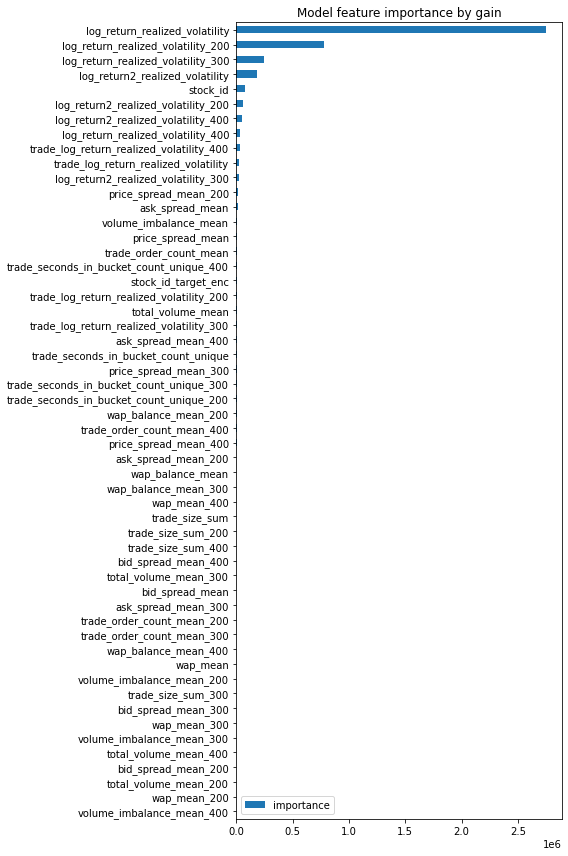

In [39]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

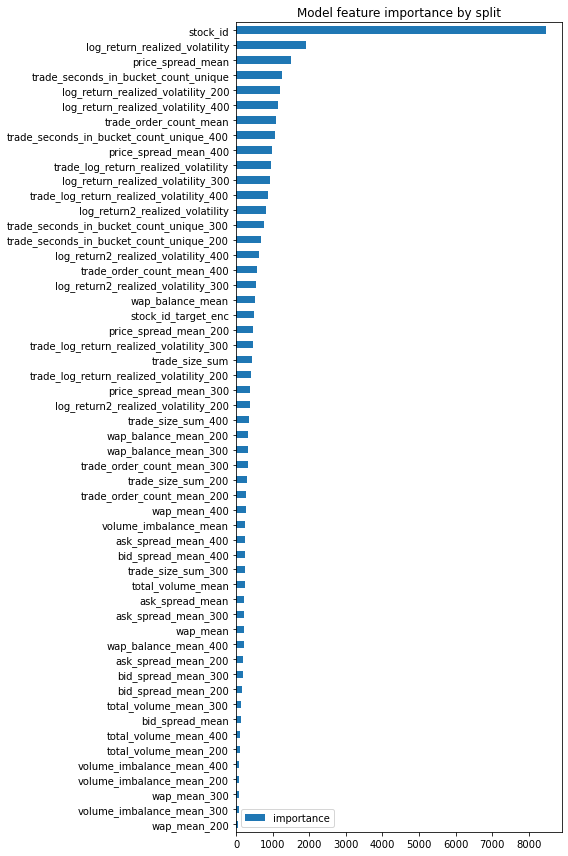

In [40]:
if DO_FEAT_IMP:
    mean_split_df = calc_mean_importance(split_importance_list)
    plot_importance(mean_split_df, title='Model feature importance by split')
    mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_split_df.to_csv('split_importance_mean.csv', index=False)

# Test set

In [41]:
df_test.columns

Index(['stock_id', 'time_id', 'row_id', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_400',
       'log_return2_realized_volatility_400', 'wap_balance_mean_400',
       'price_spread_mean_400', 'bid_spread_mean_400', 'ask_spread_mean_400',
       'volume_imbalance_mean_400', 'total_volume_mean_400', 'wap_mean_400',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'log_return_realized_volatility_200',
       'log_return2_realized_volatility_200', 'wap_balance_mean_200',
       'price_spread_mean_200', 'bid_spread_mean_200', 'ask_spread_mean_200',


In [42]:
df_train.columns

Index(['row_id', 'target', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_400',
       'log_return2_realized_volatility_400', 'wap_balance_mean_400',
       'price_spread_mean_400', 'bid_spread_mean_400', 'ask_spread_mean_400',
       'volume_imbalance_mean_400', 'total_volume_mean_400', 'wap_mean_400',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'log_return_realized_volatility_200',
       'log_return2_realized_volatility_200', 'wap_balance_mean_200',
       'price_spread_mean_200', 'bid_spread_mean_200', 'ask_spread_mean_200',
       'volum

In [43]:
y_pred = df_test[['row_id']]
X_test = df_test.drop(['time_id', 'row_id'], axis = 1)

In [44]:
X_test

,stock_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_400,log_return2_realized_volatility_400,wap_balance_mean_400,price_spread_mean_400,bid_spread_mean_400,ask_spread_mean_400,volume_imbalance_mean_400,total_volume_mean_400,wap_mean_400,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_200,log_return2_realized_volatility_200,wap_balance_mean_200,price_spread_mean_200,bid_spread_mean_200,ask_spread_mean_200,volume_imbalance_mean_200,total_volume_mean_200,wap_mean_200,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_mean_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_mean_200,stock_id_target_enc
0,0,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,350.666667,1.000405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000295,3.0,201.0,3.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [45]:
target = np.zeros(len(X_test))

#light gbm models
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [46]:
y_pred = y_pred.assign(target = target)

In [47]:
y_pred

,row_id,target
0,0-4,0.000969
1,0-32,0.000978
2,0-34,0.000978


In [48]:
y_pred.to_csv('submission.csv',index = False)